# Определение стоимости автомобилей для сервиса «Не бит, не крашен»

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка и подключение библиотек

In [1]:
!pip install scikit-learn -Uq
!pip install matplotlib -Uq
!pip install phik -Uq
!pip install seaborn -Uq

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn import set_config

from lightgbm import LGBMRegressor

import pickle
import phik
import os
from time import time


set_config(transform_output="pandas")
pd.options.mode.chained_assignment = None

### Загрузка данных

Загрузим исходные данные и отобразим общую информацию о них. Как видно, данные объёмны (более 350 тысяч строк) и в них есть пропуски:

In [3]:
def check_and_read(path, index_col=None):
    if os.path.exists(path):
        return pd.read_csv(path, index_col=index_col)
    else:
        print(f'Не найден файл по указанному пути: {path}')

        
df = check_and_read('datasets/autos.csv')
display(df)
df.info()
target = 'Price'

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Работа с пропущенными значениями

Для начала удалим столбцы с техническими данными: месяц регистрации машины, почтовый индекс пользователя, а также дату активности пользователя и дату создания анкеты. Дату скачивания анкеты тоже следует удалить, но чуть позже, так как по ней можно проверить корректность даты регистрации автомобиля.

In [4]:
df.drop(['RegistrationMonth', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1, inplace=True)

Затем изучим долю пропусков по столбцам. Пропуски есть в 5 столбцах, их доля составляет 5-20%:

In [5]:
start_size = len(df)

def check_nan(df):
    print(round(df.isna().mean()*100, 2).sort_values(ascending=False))

check_nan(df)

Repaired            20.08
VehicleType         10.58
FuelType             9.28
Gearbox              5.60
Model                5.56
DateCrawled          0.00
Price                0.00
RegistrationYear     0.00
Power                0.00
Kilometer            0.00
Brand                0.00
NumberOfPictures     0.00
dtype: float64


Посмотрим на уникальные значения для переменных *Gearbox*, *VehicleType* и *FuelType*, можно отметить их небольшое количество. Вероятно, они связаны с моделью автомобиля.

In [6]:
print(df['Gearbox'].unique())
print(df['VehicleType'].unique())
print(df['FuelType'].unique())
print(pd.Series(df['Model'].unique()).sort_values().to_numpy())

df['FuelType'].replace({'gasoline': 'petrol'}, inplace=True)
df['Model'].replace({'rangerover': 'range_rover'}, inplace=True)


['manual' 'auto' nan]
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focu

C:\Users\hydro\AppData\Local\Temp\ipykernel_15080\4215839165.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['FuelType'].replace({'gasoline': 'petrol'}, inplace=True)
C:\Users\hydro\AppData\Local\Temp\ipykernel_15080\4215839165.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

Проверим предположение о связи этих переменных с моделью автомобиля с помощью матрицы корреляций. Как видно, корреляции высокие и предположение потвердилось:

C:\Users\hydro\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable NumberOfPictures for analysis 1. Dropping this column
  warnings.warn(


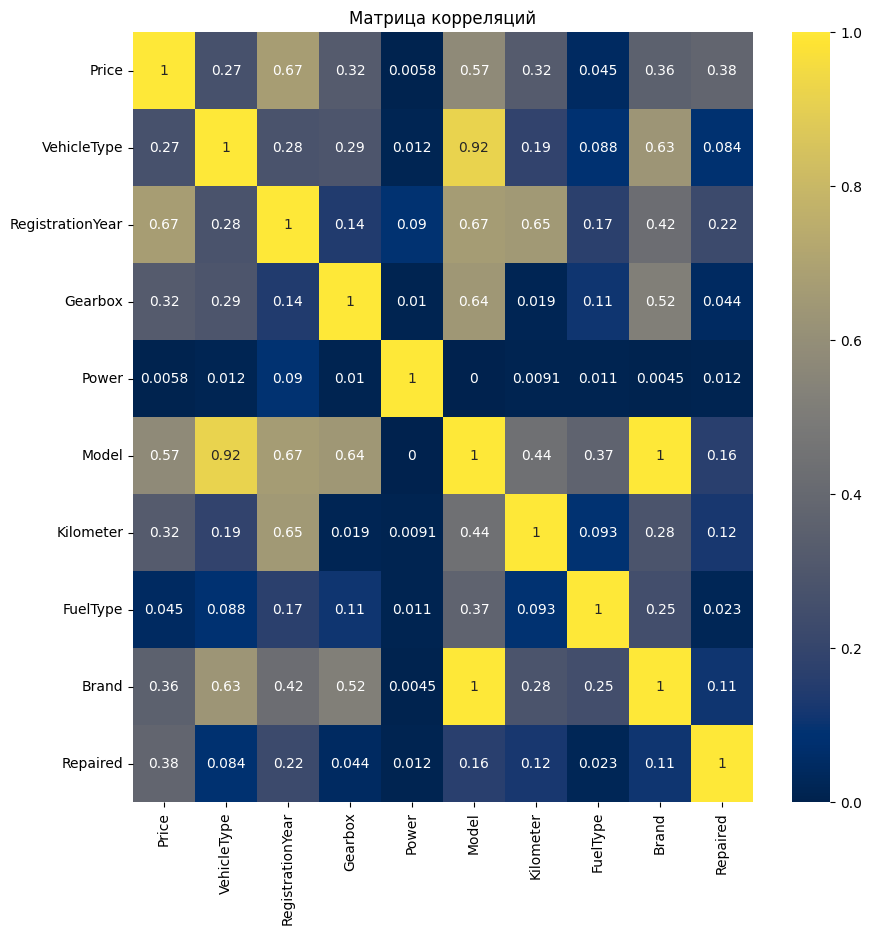

In [7]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.drop(['DateCrawled'], axis=1).phik_matrix(interval_cols=['Price', 'Power']), annot=True, cmap='cividis')
plt.title('Матрица корреляций')
plt.show()

Данные о пропущенных значениях переменной *Repaired* нельзя надёжно восстановить. В то же время, доля пропусков в этом столбце более 20% и удалять их нежелательно. В итоге, было решено проверить, что в данном столбце только значения двух типов - да и нет - и добавить для пропусков третий тип - неизвестно (*unknown*).  
Дополнительно было решено удалить столбец с количеством фотографий, так как он константный, что следует из предупреждения при построении матрицы корреляций:

In [8]:
print(df['Repaired'].unique())
df['Repaired'] = df['Repaired'].fillna('unknown')
df.drop(['NumberOfPictures'], axis=1, inplace=True)


[nan 'yes' 'no']


Для переменных с типом коробки передач, типом топлива и типом кузова примерно восстановим пропущенные значения. Для этого посчитаем моду рассматриваемых категориальных переменных для данного типа модели и её частоту, и если эта частота составляет более чем 50% случаев, заменим ей пропуски. В конце выведем итоговую долю пропусков по столбцам:

In [9]:
def replace_nan_model_based(df, column_name, seuil=0.5):
    res = df.groupby('Model')[column_name].agg(mode=pd.Series.mode, freq=lambda x: (x==x.mode()[0]).mean()).sort_values('freq')
    display(res)

    interm = df['Model'].map(lambda x: x if pd.isna(x) else res.loc[x, 'mode'] if (res.loc[x, 'freq']>seuil) else np.nan)
    mask = df[column_name].isna()
    df.loc[mask, column_name] = interm[mask]
    

In [10]:
replace_nan_model_based(df, 'VehicleType')
replace_nan_model_based(df, 'FuelType')
replace_nan_model_based(df, 'Gearbox')
check_nan(df)

,mode,freq
Model,,
other,sedan,0.221940
kaefer,sedan,0.251131
escort,sedan,0.264088
megane,sedan,0.276289
samara,sedan,0.307692
...,...,...
s60,sedan,0.979452
discovery,suv,0.987342
range_rover_sport,suv,1.000000


,mode,freq
Model,,
601,petrol,0.579952
911,petrol,0.726190
kappa,petrol,0.733333
kaefer,petrol,0.737557
auris,petrol,0.760684
...,...,...
terios,petrol,1.000000
range_rover_evoque,petrol,1.000000
serie_1,petrol,1.000000


,mode,freq
Model,,
911,manual,0.452381
x_type,manual,0.479769
9000,manual,0.483871
v_klasse,manual,0.496689
serie_1,manual,0.500000
...,...,...
gl,auto,1.000000
range_rover_evoque,auto,1.000000
samara,manual,1.000000


Model               5.56
VehicleType         4.39
FuelType            2.02
Gearbox             1.18
DateCrawled         0.00
Price               0.00
RegistrationYear    0.00
Power               0.00
Kilometer           0.00
Brand               0.00
Repaired            0.00
dtype: float64


Как видно, теперь пропуски составляют порядка 5% (для модели автомобиля) и менее. Учитывая, что надёжно восстановить модель затруднительно, доля пропусков невелика, а размер набора данных и без того внушителен, оставшиеся пропуски можно удалить:

In [11]:
df.dropna(inplace=True)

Убедимся, что пропусков не осталось и посмотрим на долю оставшихся значений. Она составляет 91,35% и это приемлемый результат:

In [12]:
df.info()
end_size=len(df)
print(f'Доля оставшихся значений: {end_size/start_size :.2%}')

<class 'pandas.core.frame.DataFrame'>
Index: 325881 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       325881 non-null  object
 1   Price             325881 non-null  int64 
 2   VehicleType       325881 non-null  object
 3   RegistrationYear  325881 non-null  int64 
 4   Gearbox           325881 non-null  object
 5   Power             325881 non-null  int64 
 6   Model             325881 non-null  object
 7   Kilometer         325881 non-null  int64 
 8   FuelType          325881 non-null  object
 9   Brand             325881 non-null  object
 10  Repaired          325881 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.8+ MB
Доля оставшихся значений: 91.96%


### Исследовательский анализ данных

Посмотрим на распределение переменных. Можно заметить некоторые аномалии в столбцах с годом регистрации автомобиля и его мощностью. Кроме того, столбцы с пробегом и годом регистрации имеют мало значений:

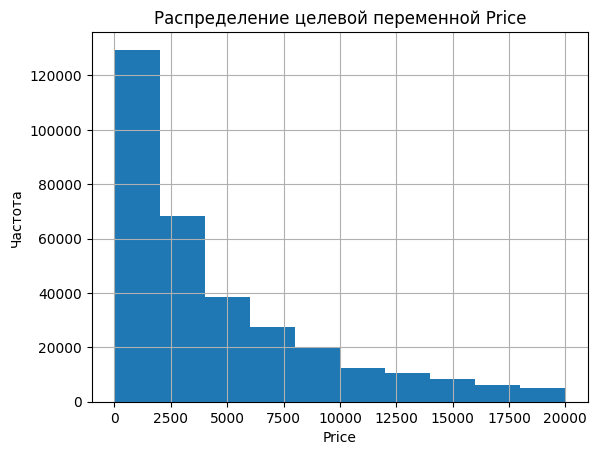

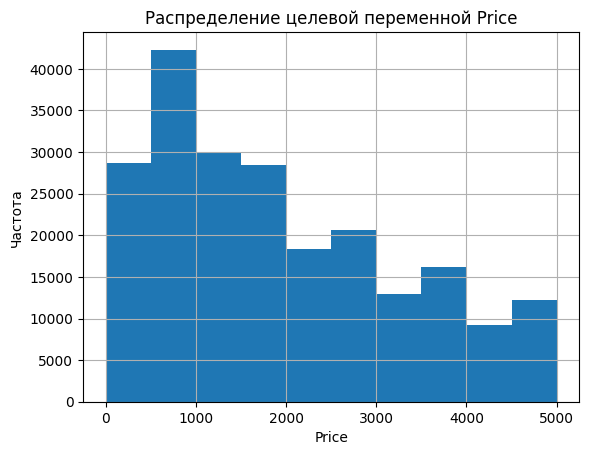

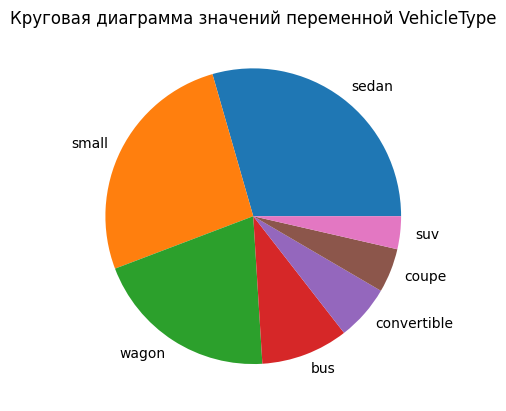

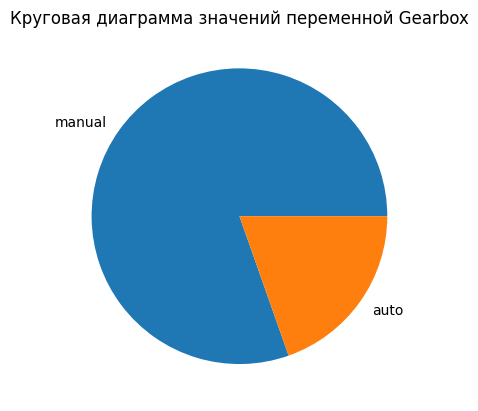

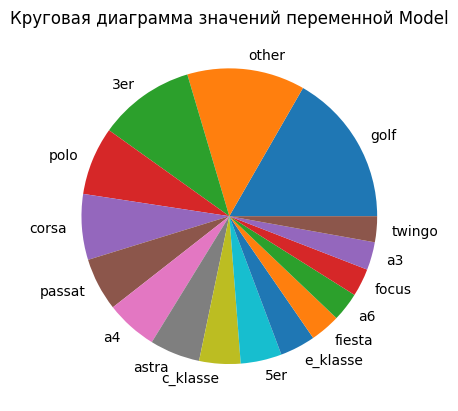

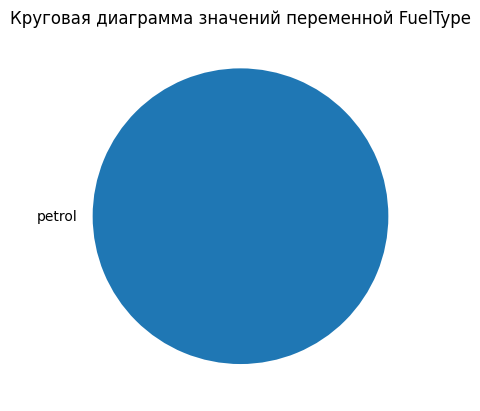

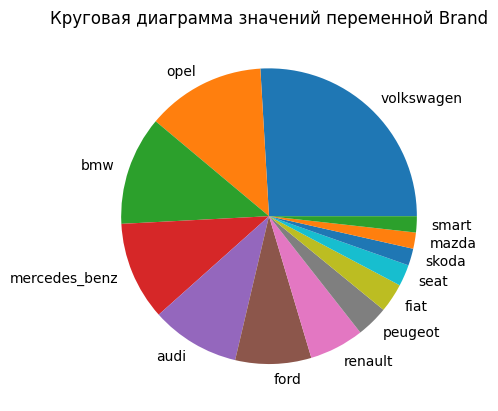

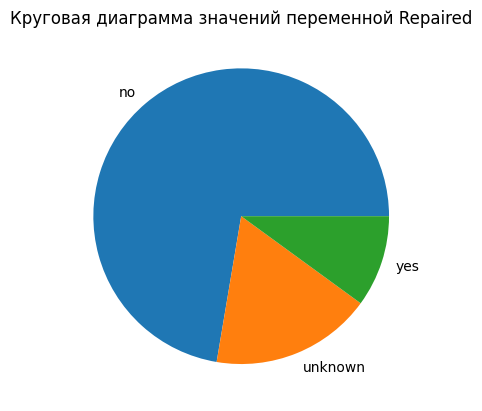

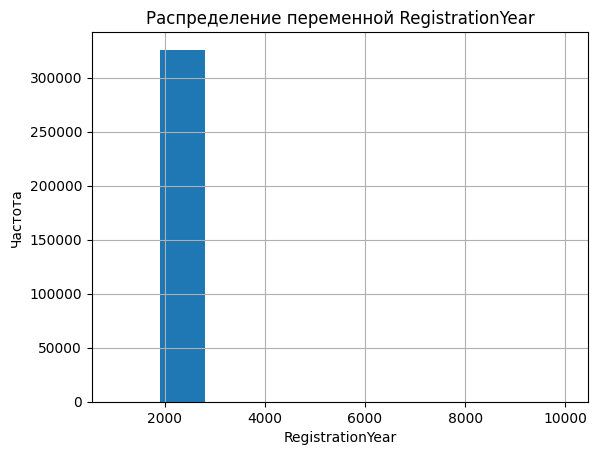

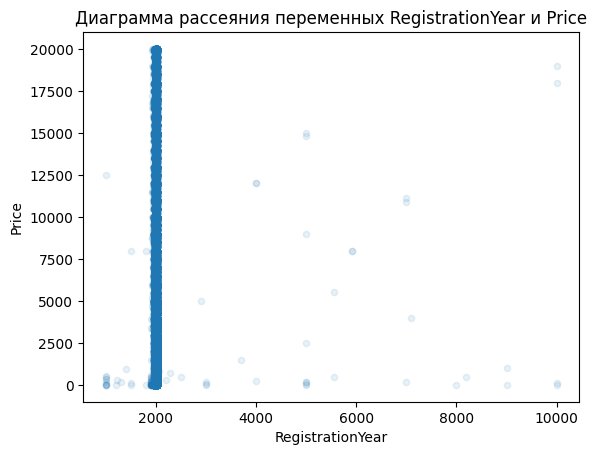

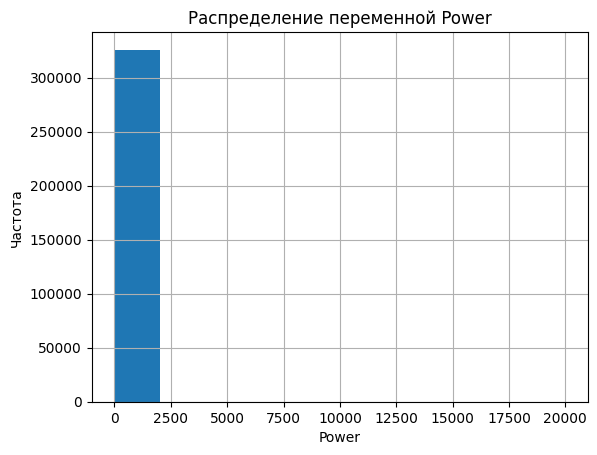

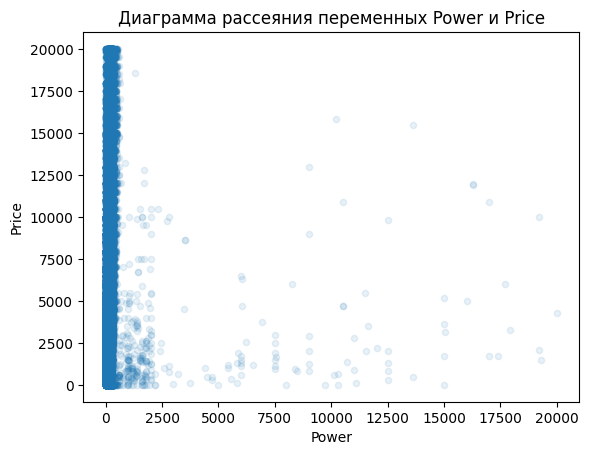

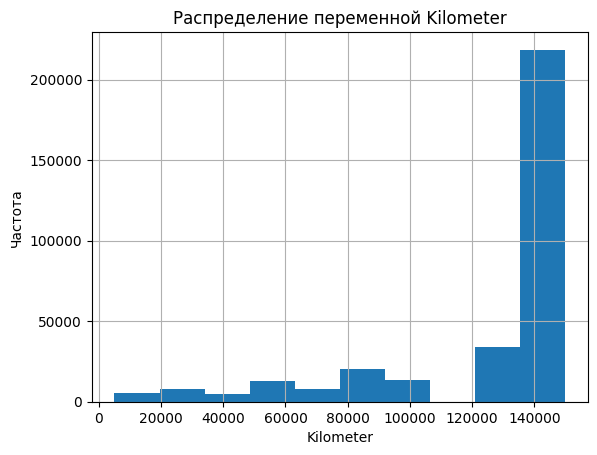

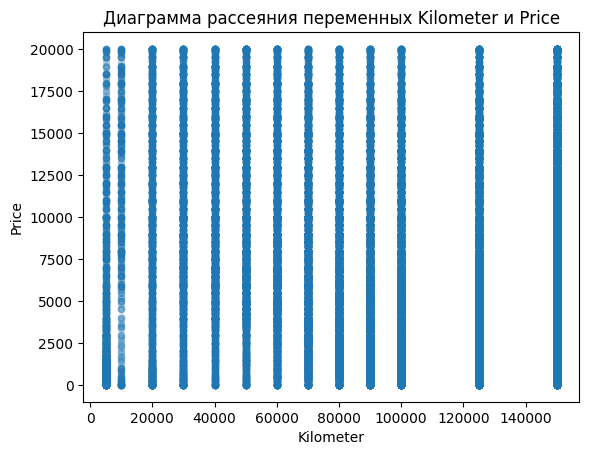

In [13]:
def plot_num(df, name, target):
    df[name].hist(bins=10)
    plt.title(f'Распределение переменной {name}')
    plt.xlabel(name)
    plt.ylabel('Частота')
    plt.show()
    
    df.plot.scatter(name, target, alpha=0.1)
    plt.title(f'Диаграмма рассеяния переменных {name} и {target}')
    plt.xlabel(name)
    plt.ylabel(target)
    plt.show()
    
    
df[target].hist(bins=10)
plt.title(f'Распределение целевой переменной {target}')
plt.ylabel('Частота')
plt.xlabel(target)
plt.show()

df[df[target]<5000][target].hist(bins=10)
plt.title(f'Распределение целевой переменной {target}')
plt.ylabel('Частота')
plt.xlabel(target)
plt.show()

for name in df.drop(['DateCrawled'], axis=1).select_dtypes('object').columns:
    plt.title(name)
    t = df[name].value_counts(normalize=True)
    t[t>0.015].plot(kind='pie')
    plt.title(f'Круговая диаграмма значений переменной {name}')
    plt.ylabel('')
    plt.show()
    
    
for name in df.drop(target, axis=1).select_dtypes('number').columns:
    plot_num(df, name, target)


Из графиков видно, что часть значений с годом регистрации машины записана некорректно, отберём их.  
Первый автомобиль был зарегистрирован в 1894 году, а верхней планкой возьмём год выгрузки анкеты из базы.  
Мощность измеряется в лошадиных силах и на графике её значения идут от 0 до 20000. Первые автомобили имели порядка 1 лошадиной силы, а верхний предел современных изредка превышает даже 3000. Тем не менее, у подавляющего большинства автомобилей мощность лежит в диапазоне от 10 до 1500 л.с. Возьмём это значение как верхнюю границу фильтрации.  
Дополнительно выведем графики после устранения выбросов и итоговую долю оставшихся значений, она составляет 79,49%:

In [14]:
df = df[(pd.DatetimeIndex(df['DateCrawled']).year>=df['RegistrationYear']) & (df['RegistrationYear']>=1894)]
df = df.drop(['DateCrawled'], axis=1)

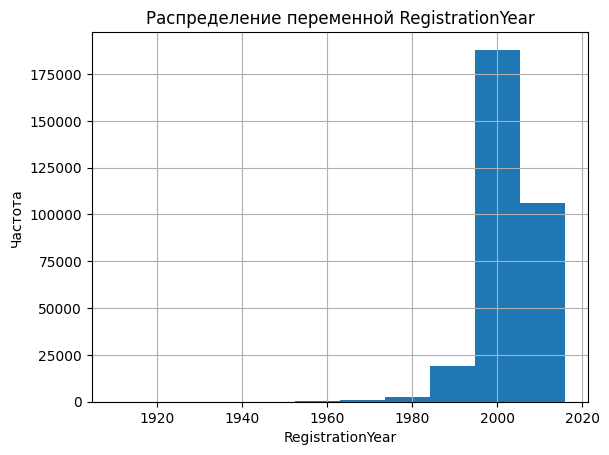

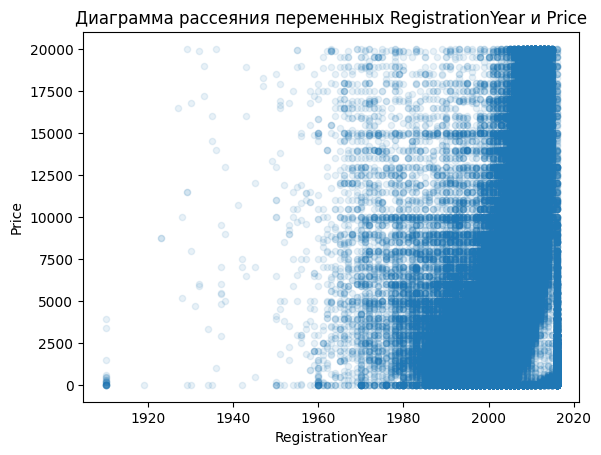

count    316653.000000
mean        113.095770
std         183.177586
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


In [15]:
plot_num(df, 'RegistrationYear', target)

print(df['Power'].describe())
df = df[(df['Power']<=1500) & (df['Power']>=10)]

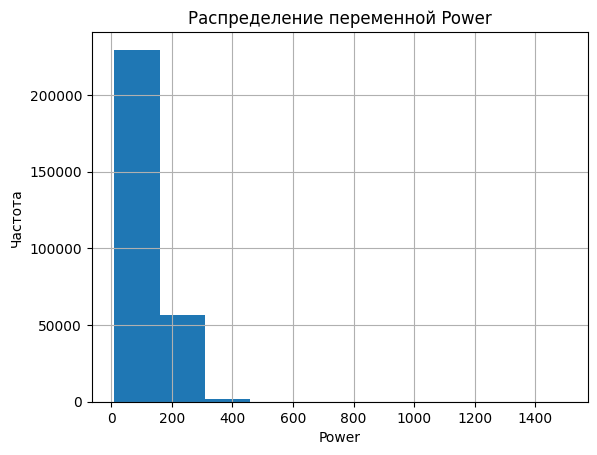

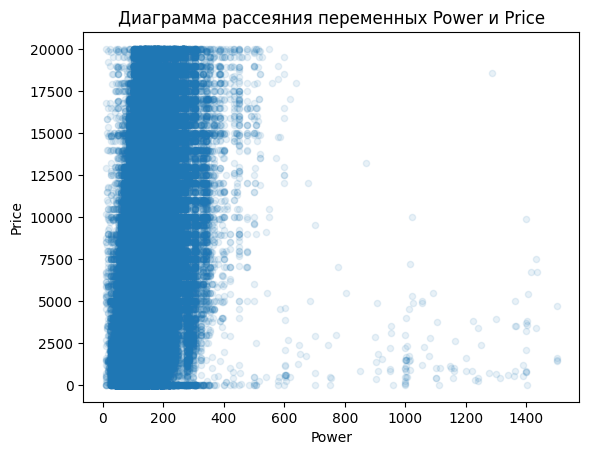

Итоговая доля оставшихся значений: 79.49%


In [16]:
plot_num(df, 'Power', target)

df = df[df['Price']>=100]

end_size=len(df)
print(f'Итоговая доля оставшихся значений: {end_size/start_size :.2%}')

## Обучение моделей

Разделим датасет на тренировочный и тестовый, в рамках пайплайна проведём предобработку значений:

In [17]:
random_state = 42

print(df.columns)
ohe_columns = ['VehicleType', 'RegistrationYear', 'Gearbox',
       'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired']
num_columns = ['Power']

for c in ohe_columns:
    df[c] = df[c].astype('category')
df.info()

X_train, X_test, y_train, y_test = train_test_split(df.drop('Price', axis=1), df['Price'], random_state=random_state)

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 281673 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             281673 non-null  int64   
 1   VehicleType       281673 non-null  category
 2   RegistrationYear  281673 non-null  category
 3   Gearbox           281673 non-null  category
 4   Power             281673 non-null  int64   
 5   Model             281673 non-null  category
 6   Kilometer         281673 non-null  category
 7   FuelType          281673 non-null  category
 8   Brand             281673 non-null  category
 9   Repaired          281673 non-null  category
dtypes: category(8), int64(2)
memory usage: 8.9 MB


In [18]:
num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', 'passthrough')
])

ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
])

In [19]:
data_preprocessor = ColumnTransformer([
    ('num', num_pipe, num_columns),
    ('ohe', ohe_pipe, ohe_columns),
],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=random_state, verbose=-1))
])

Попробуем две модели: линейную с l2 регуляризацией и градиентный бустинг. Для последнего попробуем перебрать пару значений таких гиперпараметров, как максимальная глубина дерева, количество деревьев, количество листьев и скорость обучения: 

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211254 entries, 34457 to 153403
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       211254 non-null  category
 1   RegistrationYear  211254 non-null  category
 2   Gearbox           211254 non-null  category
 3   Power             211254 non-null  int64   
 4   Model             211254 non-null  category
 5   Kilometer         211254 non-null  category
 6   FuelType          211254 non-null  category
 7   Brand             211254 non-null  category
 8   Repaired          211254 non-null  category
dtypes: category(8), int64(1)
memory usage: 5.1 MB


In [21]:
param_grid = [
    {
        'models': [Ridge(random_state=random_state, max_iter=5000)],
        'models__alpha': [0.01, 0.1, 1, 10, 100],
    },
    {
        'models': [LGBMRegressor(random_state=random_state, verbose=-1)],
        'models__max_depth': [2, 5, None],
        'models__n_estimators': [350, 700],
        'models__num_leaves': [20, 40],
        'models__learning_rate': [0.1, 0.2],
        'preprocessor__ohe': ['passthrough'],
    },
]

Запустим перебор параметров в конвейере. Как и ожидалось, градиентный бустинг оказался эффективнее. Лучшие параметры :   'models__learning_rate': 0.1, 'models__max_depth': None, 'models__n_estimators': 700, 'models__num_leaves': 40  
Ошибка RMSE при кросс-валидации составляет 1509.

In [22]:
print(data_preprocessor.fit_transform(X_train).shape)

use_prev = True
filename = 'final_model3.sav'
if use_prev:
    hyper_search = pickle.load(open(filename, 'rb'))
else:
    hyper_search = GridSearchCV(
        pipe_final,
        param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        verbose=3,
        n_jobs=-1,
        return_train_score=True,
    )
    print(pipe_final.steps)
    hyper_search.fit(X_train, y_train,)
    pickle.dump(hyper_search, open(filename, 'wb'))

print('Лучшая модель и её параметры:\n\n', hyper_search.best_estimator_)
print(hyper_search.best_params_)
print(f'Метрика RMSE лучшей модели при кросс-валидации на тренировочной выборке: {-hyper_search.best_score_:.3f}')

(211254, 393)
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   'passthrough')]),
                                                  ['Power']),
                                                 ('ohe', 'passthrough',
                                                  ['VehicleType',
                                                   'RegistrationYear',
                                                   'Gearbox', 'Model',
                                                   'Kilometer', 'FuelType',
                                                   'Brand', 'Re

## Анализ моделей

В соответствии с требованиями, сравним показатели качества (на тестом наборе данных) и скорости работы градиентного бустинга и линейной регрессии.

### Сравнение времени обучения

In [23]:
train_time = []
X_train_prepared = hyper_search.best_estimator_['preprocessor'].transform(X_train)
start = time()

hyper_search.best_estimator_['models'].fit(X_train_prepared, y_train)

end = time()
train_time.append(end-start)


In [24]:
model = Ridge(random_state=random_state, max_iter=5000)
X_train_prepared = data_preprocessor.fit_transform(X_train)
start = time()

model.fit(X_train_prepared, y_train)

end = time()
train_time.append(end-start)
train_time

[1.4020988941192627, 0.6746504306793213]

Как видно, по времени линейная регрессия примерно в 2 раза опережает своего конкурента (порядка 1,3-1,8 с против 0,6-0,8 с).

### Сравнение времени предсказания

In [25]:
pred_time = []
start = time()

hyper_search.predict(X_train)

end = time()
pred_time.append(end-start)

In [26]:
start = time()

model.predict(X_train_prepared)

end = time()
pred_time.append(end-start)
pred_time

[0.756516695022583, 0.26400017738342285]

И вновь линейная регрессия заметно впереди: время предсказания около 0,23 с против 0,76 с.

### Сравнение качества моделей

Сравним качество моделей по метрике RMSE при кросс-валидации:

In [27]:
score = [-hyper_search.best_score_, 
         -cross_val_score(model, X_train_prepared, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()]
score

[1508.8128565813781, 2091.1206985795993]

На сей раз, градиентный бустинг заметно впереди: порядка 1510 против 2090 у линейной регрессии.

### Вывод и тестовая метрика

In [28]:
display(pd.DataFrame({'Время обучения (c)': train_time, 'Время предсказания (c)': pred_time, 'Метрика качества RMSE': score}, 
                     index=['Градиентный бустинг', 'Линейная регрессия (l2-регуляризация)']).round(2))

,Время обучения (c),Время предсказания (c),Метрика качества RMSE
Градиентный бустинг,1.40,0.76,1508.81
Линейная регрессия (l2-регуляризация),0.67,0.26,2091.12


Как и ожидалось, линейная регрессия заметно быстрее градиентного бустинга (примерно в 2-3раза). Кроме того, она позволяет достичь требуемого заказчиком уровня качества (её RMSE составляет порядка 2091 против необходимых 2500).  
Градиентный бустинг, в свою очередь, заметно ниже требуемого порога (RMSE=1508) и существенно превосходит линейную регрессию по качеству. Время обучения даже на наборе данных в 210000 автомобилей составляет менее 2 секунд, что не столь существенно, а предсказание срабатывает ещё быстрее.  
Таким образом, формально в рамках поставленной задачи можно использовать любой из рассматриваемых алгоритмов, в зависимости от приоритета между временем и качеством. В данном случае, заметно более выгодным выглядит использование градиентного бустинга, так как он сильно выигрывает по качеству, а разница во времени не столь велика, и вряд ли задача дообучения или предсказания будет возникать слишком часто. В этих условиях, затраты в пару секунд на обучение выглядят пренебрежительно малыми.

В заключение, вычислим метрику на тестовом наборе данных и сравним её с результатом константной модели:

In [29]:
test_res = root_mean_squared_error(hyper_search.best_estimator_.predict(X_test), y_test)
dummy = DummyRegressor()
dummy.fit(X_train_prepared, y_train)
dummy_res = root_mean_squared_error(dummy.predict(data_preprocessor.transform(X_test)), y_test)
print(f'Градиентный бустинг: {test_res:.2f}, Константная модель: {dummy_res:.2f}')

C:\Users\hydro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Градиентный бустинг: 1493.45, Константная модель: 4622.10


Показатель на тестовом датасете: 1493, что даже чуть лучше, чем при кросс-валидации. Видно, что константная модель имеет ошибку почти в 3 раза выше, а значит использование бустинга оправдано.